In [34]:
#Req1
#Libraries Importing

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar100
from sklearn.model_selection import train_test_split
from keras import layers,Sequential
from keras.layers import Conv2D, Flatten, Dense,MaxPooling2D,Dropout
from tensorflow.keras.utils import to_categorical
import optuna
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
#Data Loading
(x, y)= cifar100.load_data()[0]
fine_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle',
    'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle',
    'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur',
    'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard',
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain',
    'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree',
    'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket',
    'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider',
    'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor',
    'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]


In [36]:
#Data Splitting
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.9, random_state=42)

x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,train_size=0.89,random_state=42)


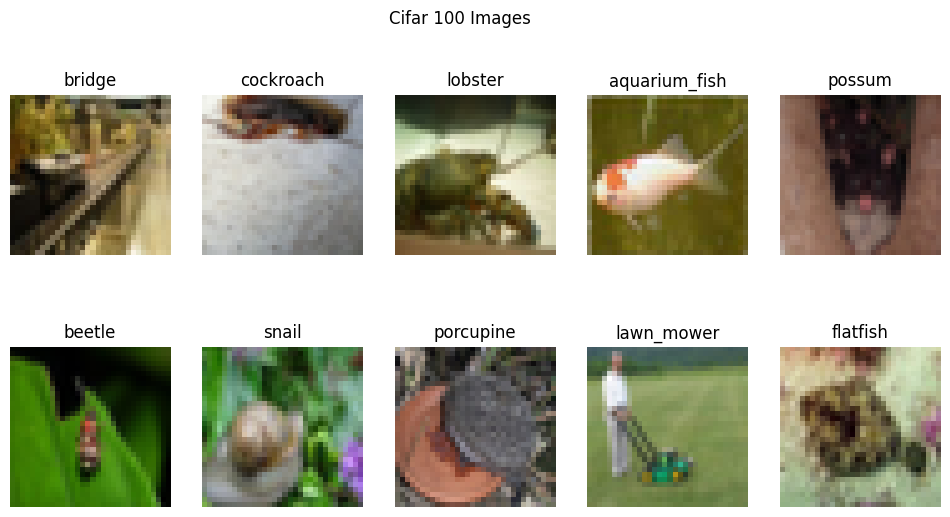

In [37]:
#Plotting 10 different classes
plt.figure(figsize=(12,6))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(x_train[i])
    plt.title(f"{fine_labels[y_train[i][0]]}")
    plt.axis('off')
plt.suptitle('Cifar 100 Images')
plt.show()

In [38]:
#Dataset Information
print("Number of Classes :",len(np.unique(y)))
print(f"Shape of data {x[0].shape}")
print(f"Training data size {x_train.shape[0]}")
print(f"Testing data size {x_test.shape[0]}")
print(f"Validation data size {x_val.shape[0]}")

Number of Classes : 100
Shape of data (32, 32, 3)
Training data size 40050
Testing data size 5000
Validation data size 4950


In [39]:
#Req2
datagen = ImageDataGenerator(
    rotation_range=20,            # Random rotations in degrees
    width_shift_range=0.2,        # Random horizontal translations
    height_shift_range=0.2,       # Random vertical translations
    shear_range=0.2,              # Random shear transformations
    zoom_range=0.2,               # Random zoom
    horizontal_flip=True,         # Random horizontal flip
    fill_mode='nearest'           # Fill mode for newly created pixels
)

    # Fit the generator on the training data
datagen.fit(x_train)
#Data Normalization [0:1]
x_train_norm = x_train/255.0
x_test_norm = x_test/255.0
x_val_norm = x_val/255.0

#Categerize the output into 100 classes
y_train_cate = to_categorical(y_train,100)
y_val_cate = to_categorical(y_val,100)
y_test_cate = to_categorical(y_test,100)

In [40]:
#Req3
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,  # Stop after 3 epochs without improvement
                               restore_best_weights=True)
def objective(trial):
    # Hyperparameters to tune
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    num_layers = trial.suggest_int('num_layers', 1, 3)
    filters = trial.suggest_int('filters', 32, 256, step=32)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
    l2_strength = trial.suggest_loguniform('l2_strength', 1e-5, 1e-2)
    
    model = Sequential()
    model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(32, 32, 3),
                            kernel_regularizer=keras.regularizers.l2(l2_strength)))
    model.add(Dropout(dropout_rate))
    for _ in range(num_layers):
         model.add(Conv2D(filters, (3, 3), activation='relu', input_shape=(32, 32, 3),
                            kernel_regularizer=keras.regularizers.l2(l2_strength)))
         model.add(Dropout(dropout_rate))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D())

    # Fully connected layers
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(l2_strength)))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(100, activation='softmax'))  # 100 classes in CIFAR-100    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    model.fit(x_train_norm, y_train_cate, epochs=20, batch_size=batch_size, 
              validation_data=(x_val_norm, y_val_cate), verbose=0 ,callbacks=[early_stopping])
    accuracy = model.evaluate(x_val_norm, y_val_cate, verbose=0)
    return accuracy[1]  # Return validation accuracy


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)  # Run for 30 trials

# Print best hyperparameters
print("Best hyperparameters:", study.best_params)

[I 2025-04-27 17:30:31,699] A new study created in memory with name: no-name-88421aa2-6150-452f-8a6b-2420458c65aa
/tmp/ipykernel_31/874956907.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
/tmp/ipykernel_31/874956907.py:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)
/tmp/ipykernel_31/874956907.py:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_strength = trial.suggest_loguniform('l2_str

Best hyperparameters: {'learning_rate': 0.00017132805545779658, 'batch_size': 64, 'num_layers': 1, 'filters': 256, 'dropout_rate': 0.2842644427252522, 'l2_strength': 3.247908430903704e-05}


In [43]:
best_params = study.best_params 
best_model = Sequential()

# Add the first Conv2D layer with the best hyperparameters
best_model.add(layers.Conv2D(best_params['filters'], (3, 3), activation='relu', input_shape=(32, 32, 3),
                             kernel_regularizer=keras.regularizers.l2(best_params['l2_strength'])))
best_model.add(layers.Dropout(best_params['dropout_rate']))

# Add additional Conv2D layers
for _ in range(best_params['num_layers'] - 1):
    best_model.add(layers.Conv2D(best_params['filters'], (3, 3), activation='relu',
                                 kernel_regularizer=keras.regularizers.l2(best_params['l2_strength'])))
    best_model.add(layers.Dropout(best_params['dropout_rate']))

# Add the remaining layers (you can adjust as needed)
best_model.add(layers.Conv2D(256, (3, 3), activation='relu'))
best_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
best_model.add(layers.MaxPooling2D())

best_model.add(layers.Flatten())
best_model.add(layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(best_params['l2_strength'])))
best_model.add(layers.Dense(100, activation='softmax'))  # 100 classes for CIFAR-100

# Compile the model
best_model.compile(optimizer=keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                   loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the full training data
best_model.fit(x_train_norm, y_train_cate, epochs=20, 
               batch_size=best_params['batch_size'], validation_data=(x_val_norm, y_val_cate))


Epoch 1/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 20s 26ms/step - accuracy: 0.0454 - loss: 4.3761 - val_accuracy: 0.1521 - val_loss: 3.7068
Epoch 2/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.1720 - loss: 3.5537 - val_accuracy: 0.2240 - val_loss: 3.3104
Epoch 3/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.2545 - loss: 3.1141 - val_accuracy: 0.2580 - val_loss: 3.0938
Epoch 4/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.3152 - loss: 2.8014 - val_accuracy: 0.2830 - val_loss: 2.9640
Epoch 5/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.3706 - loss: 2.5276 - val_accuracy: 0.3018 - val_loss: 2.8863
Epoch 6/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.4287 - loss: 2.2697 - val_accuracy: 0.3222 - val_loss: 2.7832
Epoch 7/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.4795 - loss: 2.0281 - val_accuracy: 0.3283 - val_loss: 2.8030
Epoch 8/20
626/626 ━━━━━━━━━━━━━━━━━━━━ 14s 22ms/step - accuracy: 0.5347 - loss: 1.7942 - 

In [45]:
loss, accuracy = best_model.evaluate(x_test_norm,y_test_cate)

157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3110 - loss: 6.7178


NameError: name 'x_test_norm' is not defined